# 09/09/2021 - Harris interactive pour Challenges (vague 12)

In [1]:
import numpy as np
import requests

import altair as alt
import matplotlib.pyplot as plt
from pywaffle import Waffle
alt.data_transformers.enable('data_server')

from pollsposition.plots import stripplot, comparisonplot, sample_uncertainty


%load_ext autoreload
%autoreload 2

In [5]:
SONDAGE = '20210906_harris'

## Load the data

In [6]:
r = requests.get("https://raw.githubusercontent.com/pollsposition/data/main/presidentielles/sondages.json")
polls = r.json()

In [7]:
sondage = polls[SONDAGE]
num_interroges = sondage['echantillon']
hypotheses = sondage['hypotheses']

## Calculer les distributions postérieures

On choisit d'abord de voir le blanc/nul comme un candidat à part entière, on réajuste donc les pourcentages:

In [15]:
def inclure_non_exprimes(hypothese):
    resultats_bruts = hypothese['intentions']
    
    if not hypothese['intentions_exprimees']:
        return resultats_bruts
    
    resultats = {}
    resultats['Blancs/Nul'] = 100 - hypothese['intentions_exprimees']
    for k,r in resultats_bruts.items():
        resultats[k] = hypothese['intentions_exprimees'] / 100 * r
        
    return resultats

In [16]:
subtitle = "Intentions de vote au premier tour des élections présidentielles 2022"
source = f"Harris interactive pour Challenges (06/09/2021)"

figures = {}
for key, name in hypotheses.items():
    resultats = inclure_non_exprimes(sondage['premier_tour'][key])
    posterior = sample_uncertainty(num_interroges, resultats, samples=1000)
    
    title = f"{name}"
    fig = stripplot(posterior, title=title, subtitle=subtitle, source=source, sort=None)
    figures[key] = fig

We can display the figures individually below:

In [19]:
figures['bertrand']

alt.ConcatChart(...)

And save them in bulk:

In [18]:
for key, fig in figures.items():
    fig.save(f"resultats_distributions_{SONDAGE}_{key}.png", scale_factor=5.)

## Comparer les candidatures Pécresse, Bertrand et Barnier


In [33]:
posteriors_all = {hyp_id: sample_uncertainty(num_interroges * 0.7, sondage['premier_tour'][hyp_id]['intentions'], 1000) for hyp_id in ['bertrand', 'pecresse', 'barnier']}
posterior = {
    'Xavier Bertrand': posteriors_all['bertrand']['Xavier Bertrand'],
    'Valérie Pécresse': posteriors_all['pecresse']['Valérie Pécresse'],
    'Michel Barnier': posteriors_all['barnier']['Michel Barnier'],
}

title="Comparaison des candidats de la droite (sans Zemmour)"
plot = stripplot(posterior, title=title, subtitle=subtitle, source=source, sort=None, domain=[0,26])
plot.save(f"comparaison_candidats_droite_{SONDAGE}.png")
plot

alt.ConcatChart(...)

On calcule (et représente) la probabilité que Pécresse et Barnier fassent un meilleur score que Bertrand:

In [34]:
p_pecresse_greater = np.sum(posterior['Valérie Pécresse'] > posterior['Xavier Bertrand']) /  1_000
print(f"Il y a {100*p_pecresse_greater:.1f}% de chance que Valérie Pécresse réunisse plus d'intentions de votes.")

Il y a 14.9% de chance que Valérie Pécresse réunisse plus d'intentions de votes.


14


/tmp/ipykernel_5402/1187656967.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


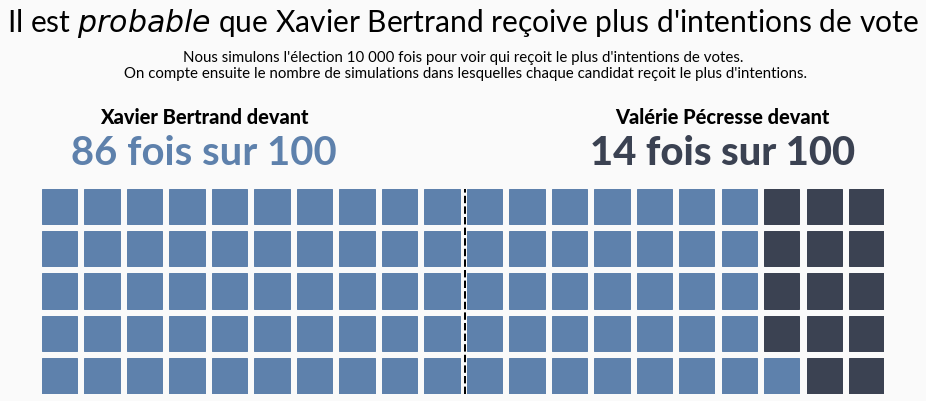

In [35]:
num_pecresse = int(100*p_pecresse_greater)
data = {'Xavier Bertrand':100-num_pecresse, 'Valérie Pécresse': num_pecresse}

plt.rcParams['font.family'] = 'Lato'
#plt.rcParams['font.sans-serif'] = 'Futura'

print(num_pecresse)
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=20,  # Either rows or columns could be omitted
    values=list(data.values()),
    figsize=(12,8),
    colors=["#5e81ac", "#3b4252"]
)
fig.ax.axvline(x=2.06, ymax=3, ls='--', lw=2, color='black')
fig.text(
    x=0.2,
    y=0.79,
    ha="center",
    s="Xavier Bertrand devant",
        fontweight="heavy",
    fontsize=20,
)
fig.text(
    x=0.2,
    y=0.72,
    ha="center",
    s=f"{100-num_pecresse} fois sur 100",
    fontsize=40,
    fontweight="bold",
    color="#5e81ac"
)
fig.text(
    x=0.8,
    y=0.79,
    ha="center",
    s="Valérie Pécresse devant",
        fontweight="heavy",
    fontsize=20,
)
fig.text(
    x=0.8,
    y=0.72,
    ha="center",
    s=f"{num_pecresse} fois sur 100",
    fontsize=40,
    fontweight="heavy",
    color="#3b4252"
)
fig.text(
    x=0.5,
    y=0.95,
    ha="center",
    s="Il est $\it{probable}$ que Xavier Bertrand reçoive plus d'intentions de vote",
    fontsize=30
)
fig.text(
    x=0.5,
    y=0.87,
    ha="center",
    s="Nous simulons l'élection 10 000 fois pour voir qui reçoit le plus d'intentions de votes.\n On compte ensuite le nombre de simulations dans lesquelles chaque candidat reçoit le plus d'intentions.",
    fontsize=15
)
fig.show()
fig.set_facecolor('#fafafa')

In [37]:
p_barnier_greater = np.sum(posterior['Michel Barnier'] > posterior['Xavier Bertrand']) /  1_000
print(f"Il y a {100*p_barnier_greater:.1f}% de chance que Michel Barnier réunisse plus d'intentions de votes.")

Il y a 0.0% de chance que Michel Barnier réunisse plus d'intentions de votes.


1


/tmp/ipykernel_5402/1821382018.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


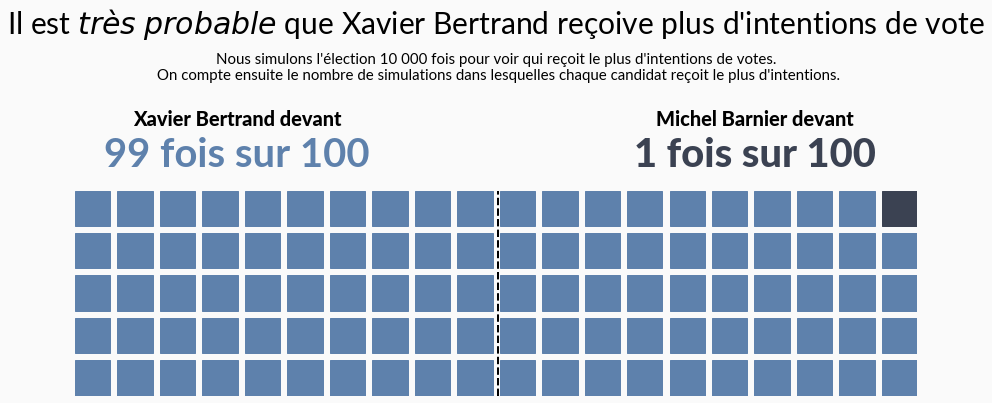

In [40]:
num_pecresse = 1#int(100*p_barnier_greater)
data = {'Xavier Bertrand':100-num_pecresse, 'Michel Barnier': num_pecresse}

plt.rcParams['font.family'] = 'Lato'
#plt.rcParams['font.sans-serif'] = 'Futura'

print(num_pecresse)
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=20,  # Either rows or columns could be omitted
    values=list(data.values()),
    figsize=(12,8),
    colors=["#5e81ac", "#3b4252"]
)
fig.ax.axvline(x=2.06, ymax=3, ls='--', lw=2, color='black')
fig.text(
    x=0.2,
    y=0.79,
    ha="center",
    s="Xavier Bertrand devant",
        fontweight="heavy",
    fontsize=20,
)
fig.text(
    x=0.2,
    y=0.72,
    ha="center",
    s="99 fois sur 100",
    fontsize=40,
    fontweight="bold",
    color="#5e81ac"
)
fig.text(
    x=0.8,
    y=0.79,
    ha="center",
    s="Michel Barnier devant",
    fontweight="heavy",
    fontsize=20,
)
fig.text(
    x=0.8,
    y=0.72,
    ha="center",
    s=f"{num_pecresse} fois sur 100",
    fontsize=40,
    fontweight="heavy",
    color="#3b4252"
)
fig.text(
    x=0.5,
    y=0.95,
    ha="center",
    s="Il est $\it{très}$ $\it{probable}$ que Xavier Bertrand reçoive plus d'intentions de vote",
    fontsize=30
)
fig.text(
    x=0.5,
    y=0.87,
    ha="center",
    s="Nous simulons l'élection 10 000 fois pour voir qui reçoit le plus d'intentions de votes.\n On compte ensuite le nombre de simulations dans lesquelles chaque candidat reçoit le plus d'intentions.",
    fontsize=15
)
fig.show()
fig.set_facecolor('#fafafa')

### Si Zemmour est candidat

In [14]:
resultats_comparaison = {
    'Xavier Bertrand': sondage['premier_tour']['bertrand_zemmour']['intentions']['Xavier Bertrand'],
    'Valérie Pécresse': sondage['premier_tour']['pecresse_zemmour']['intentions']['Valérie Pécresse'],
    'Michel Barnier': sondage['premier_tour']['barnier_zemmour']['intentions']['Michel Barnier'],
}
posterior = sample_uncertainty(
    num_interroges,
    resultats_comparaison,
    len(sondage['premier_tour']['bertrand']['intentions']), # number of candidates
    samples=1000
)

title="Comparaison des candidats de la droite (avec Zemmour)"
plot = stripplot(posterior, title=title, subtitle=subtitle, source=source, sort=None, domain=[0,26])
plot.save(f"comparaison_candidats_droite_{SONDAGE}_zemmour.png")
plot

alt.ConcatChart(...)

## Impact de la candidature d'Eric Zemmour

Le sondage amène naturellement à comparer les situations avec/sans Eric Zemmour.

In [41]:
comparison = comparisonplot(
    sondage['premier_tour']['bertrand']['intentions'],
    sondage['premier_tour']['bertrand_zemmour']['intentions'],
    title="Hypothèse Bertrand: impact de la candidature d'Eric Zemmour",
    subtitle="Sur les intentions de votes des candidats. En points de pourcentage",
    source=source,
)
comparison.save(f"impact_zemmour_bertrand_{SONDAGE}.png", scalefactor=5)
comparison

alt.ConcatChart(...)